In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext
getcontext().prec = 10  # Set the precision to 10 decimal places

alpha=0.01
gamma=.9
Testsize=300

'''
n = 300
nfog = 30
ncloud=30
'''

'''
n = 300
nfog = 30
ncloud=70
'''

'''
n = 400
nfog = 50
ncloud=80
'''
'''
n = 400
nfog = 25
ncloud=50
'''

'''
n = 400
nfog = 35
ncloud=40
'''


'''
n = 500
nfog = 70
ncloud=100
'''

'''
n = 500
nfog = 30
ncloud=60
'''

n = 500
nfog = 45
ncloud=45


'''
n = 200
nfog = 20
ncloud=50
'''
'''
n = 200
nfog = 15
ncloud=30
'''
'''
n = 200
nfog = 22
ncloud=23
'''


'''
n = 150
nfog = 20
ncloud=30

'''

'''
n = 100
nfog = 10
ncloud=20
'''

'''
n = 100
nfog = 15
ncloud=15
'''


'''
n = 100
nfog = 10
ncloud=20
'''
'''
n = 70
nfog = 5
ncloud=15
'''

totalnodes=nfog+ncloud

Episodes=100000
NumberofAvg = 100
episode_rewards=[]
episode_rewards_q=[]
episode_rewards_task=np.zeros([Episodes,n])
episode_positive_rewards_number=np.zeros([Episodes])

episode_deadline_hit=np.zeros(Episodes)

Test__deadline_hit=np.zeros([Testsize,n])
Test__violation_time=np.zeros([Testsize,n])

high_priority__violation_time=np.zeros([Testsize])
low_priority__violation_time=np.zeros([Testsize])

high_priority_miss_deadline=np.zeros([Testsize])
low_priority_miss_deadline=np.zeros([Testsize])

N_high_priority_task=np.zeros([Testsize])
N_low_priority_task=np.zeros([Testsize])



Generated_Tasks_size=np.zeros([Testsize,n])
Generated_Tasks_Data=np.zeros([Testsize,n])
Generated_Tasks_Deadline=np.zeros([Testsize,n])
Generated_Tasks_prio=np.zeros([Testsize,n])
Generated_Tasks_prio_Normalized=np.zeros([Testsize,n])

ResourcePerformance=np.zeros(totalnodes)


C1=n/100           # reward for tasks that meet  their deadline
C2=n/400
C3=n/50
#----------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------
#------------------------------   Task specification-------------------------------------
#----------------------------------------------------------------------------------------

TaskPriority = np.zeros(n)
Normalized_TaskPriority = np.zeros(n)
TaskData= np.zeros(n)
TaskSize = np.zeros(n)
TaskDeadline = np.zeros(n)
MeetDealine=np.zeros(n)
Wait_queue=np.zeros(n)
RunTime=np.zeros(n)
DTT=np.zeros(n)
Makespan=np.zeros(n)
Assigned_Resource=np.zeros(n)
#----------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------
#------------------------------   Resource specification---------------------------------
#----------------------------------------------------------------------------------------

#ResourcePerformance= [6,8,12,14,15,16,17]

a_size_fognode=3000
b_size_fognode=5000


a_size_cloudnode=7000
b_size_cloudnode=12000


for i in range(totalnodes):
  if i<nfog:
     ResourcePerformance[i]=random.randint(a_size_fognode,b_size_fognode)
  else:
     ResourcePerformance[i]=random.randint(a_size_cloudnode,b_size_cloudnode)



ResourceQueue=[[]]*(nfog+ncloud)
UsedResource = np.ones ([1,nfog+ncloud])
for i in range(nfog):
  UsedResource [0,i] =2

for i in range(nfog ,nfog+ncloud):
  UsedResource [0,i] =20
'''
Fog_bandwidth=4000
Cloud_bandwidth=1000
'''

Fog_bandwidth=1000
Cloud_bandwidth=100



def softmax(x):
    """
    Compute the softmax function for a vector x.

    Args:
        x (numpy.ndarray): Input vector.

    Returns:
        numpy.ndarray: Probability distribution.
    """
    exp_x = np.exp(x - np.max(x))  # Subtracting np.max(x) for numerical stability
    return exp_x / exp_x.sum(axis=0, keepdims=True)

#----------------------------------------------------------------------------------------
#-----------------------------    Create tasks              -----------------------
#----------------------------------------------------------------------------------------
low_a_pri=1
low_b_pri=2

high_a_pri=3
high_b_pri=5

'''
a_dl=20
b_dl=30
a_size_dataintensive=30
b_size_dataintensive=60
a_size_computeintensive=60
b_size_computeintensive=100

a_data_dataintensive=1000
b_data_dataintensive=1500
a_data_computeintensive=100
b_data_computeintensive=700
'''

'''
a_dl_dataintensive=100
b_dl_dataintensive=500

a_dl_computintensive=500
b_dl_computintensive=2500
'''
a_dl_dataintensive=10
b_dl_dataintensive=50

a_dl_computintensive=50
b_dl_computintensive=250

a_size_dataintensive=100
b_size_dataintensive=400

a_size_computeintensive=1000
b_size_computeintensive=4000

a_data_dataintensive=1000
b_data_dataintensive=5000

a_data_computeintensive=100
b_data_computeintensive=500


def Generat_Tasks():
  data_intensive_prob=.3
  for i in range(n):
    #if random.uniform(0, 1) < data_intensive_prob:
    if i <n/3-1:
     # TaskDeadline[i]=random.randint(a_dl_dataintensive, b_dl_dataintensive)
      TaskDeadline[i]=random.uniform(a_dl_dataintensive, b_dl_dataintensive)
      TaskPriority[i]= random.randint(high_a_pri, high_b_pri)
      TaskSize[i]=random.randint(a_size_dataintensive, b_size_dataintensive)
      TaskData[i]= random.randint(a_data_dataintensive,b_data_dataintensive)
    else:
      #TaskDeadline[i]=random.randint(a_dl_computintensive, b_dl_computintensive)
      TaskDeadline[i]=random.uniform(a_dl_computintensive, b_dl_computintensive)
      TaskPriority[i]= random.randint(low_a_pri, low_b_pri)
      TaskSize[i]=random.randint(a_size_computeintensive, b_size_computeintensive)
      TaskData[i]= random.randint(a_data_computeintensive,b_data_computeintensive)

#----------------------------------------------------------------------------------------
#-----------------------------                  -----------------------------------------
#-----------------------------                  -----------------------------------------
#-----------------------------    Class Task     -----------------------------------------
#-----------------------------                  -----------------------------------------
#-----------------------------                  -----------------------------------------
#----------------------------------------------------------------------------------------
class Task:
    def __init__(self, TaskId, TaskSize, TaskData, TaskDeadline, TaskPriority ):
        self.TaskId =TaskId
        self.TaskSize =TaskSize
        self.TaskData = TaskData
        self.TaskDeadline = TaskDeadline
        self.TaskPriority = TaskPriority
        self.runtime = 0
        self.starttime=0
        self.waitingtime=0
        self.meetdeadline=0
        self.makespan=0

    def set_waitingtime(self, waitingtime):
       self.waitingtime=waitingtime

    def set_starttime(self, starttime):
       self.starttime=starttime

    def set_meetdeadline(self, meetdeadline):
       self.meetdeadline=meetdeadline

    def set_makespan(self, makespan):
       self.makespan=makespan

    def set_runtime(self, runtime):
       self.runtime=runtime

    def get_makespan(self):
       return self.makespan


#----------------------------------------------------------------------------------------
#-----------------------------                  -----------------------------------------
#-----------------------------                  -----------------------------------------
#-----------------------------  Class Tasklist  -----------------------------------------
#-----------------------------                  -----------------------------------------
#-----------------------------                  -----------------------------------------
#----------------------------------------------------------------------------------------

class TaskList:
    def __init__(self, ntask):
        self.ntask = ntask
        self.tasklist = []

    def add_task(self, TaskId, TaskSize, TaskData, TaskDeadline, TaskPriority):
        task = Task(TaskId, TaskSize, TaskData, TaskDeadline, TaskPriority)
        self.tasklist.append(task)

    def sort_subtasks_by_priority(self):
        self.tasklist.sort(key=lambda x: x.TaskPriority, reverse=True)

    def get_tasklist(self):
        return self.tasklist

    def show_tasklist(self):
      for i, subtask in enumerate(self.tasklist):
        print(f"Subtask {i+1}: Size {subtask.size}, Priority {subtask.priority}")
        print()
#------------------------------------------------------------------------------------------------------------
#-----------------------------                                      -----------------------------------------
#-----------------------------                                      -----------------------------------------
#-----------------------------    Class TaskAssignmentEnvironment   -----------------------------------------
#-----------------------------                                      -----------------------------------------
#-----------------------------                                      -----------------------------------------
#------------------------------------------------------------------------------------------------------------


class TaskAssignmentEnvironment:
    def __init__(self, n, nfog, ncloud):
        self.n = n
        self.nfog = nfog
        self.ncloud = ncloud
        self.state_space = n
        self.action_space = nfog + ncloud
        self.queue=[[] for _ in range(nfog + ncloud)]


    def add_task_to_queue(self, action, state):
      if 0 <= action < len(self.queue):
          self.queue[action].append(state)
          return True
      else:
          print('out of index')
          return False


    def get_state(self):
        return random.randint(0, self.state_space - 1)

    def take_action1(self):
      reward=0
      for j in range(n):
        state=j
        #print(state)
        action = agent.choose_action(state)
        run_time = TaskSize[state] /  ResourcePerformance[action]
        node = action
        waiting_time=0
        for i in self.queue[action]:
          #waiting_time+=TaskSize[i] /  ResourcePerformance[action]
           waiting_time+=Makespan[i]
        self.add_task_to_queue( action, state)
        if node < self.nfog:
            response_time = waiting_time+ run_time + (TaskData[state] /Fog_bandwidth)  # consider data transfer time for fog response time
        else:
            response_time =waiting_time+ run_time + (TaskData[state] /Cloud_bandwidth)  #  consider data transfer time for cloud response time

        Wait_queue[state]= waiting_time
        Makespan[state]=response_time
        # Reward function (considering task deadline)
        if response_time<= TaskDeadline[state]:
           #reward = response_time *Normalized_TaskPriority[state]*C1
           reward += Normalized_TaskPriority[state]*C1
           #reward = C1*TaskPriority[state]
           #reward = response_time *TaskPriority[state]
           MeetDealine[state]=1
        else:
          reward -= (response_time-TaskDeadline[state])*Normalized_TaskPriority[state]*C2
          #reward = -(response_time-TaskDeadline[state])*TaskPriority[state]*C2
          #reward = -C2

        Assigned_Resource[state]=node
        return state, node, reward




    def take_action(self, state, action):
        run_time = TaskSize[state] /  ResourcePerformance[action]
        node = action
        waiting_time=0
        for i in self.queue[action]:
          #waiting_time+=TaskSize[i] /  ResourcePerformance[action]
           waiting_time+=Makespan[i]
        self.add_task_to_queue( action, state)
        if node < self.nfog:
            response_time = waiting_time+ run_time + (TaskData[state] /Fog_bandwidth)  # consider data transfer time for fog response time
        else:
            response_time =waiting_time+ run_time + (TaskData[state] /Cloud_bandwidth)  #  consider data transfer time for cloud response time

        Wait_queue[state]= waiting_time
        Makespan[state]=response_time
        # Reward function (considering task deadline)
        if response_time<= TaskDeadline[state]:
           #reward = response_time *Normalized_TaskPriority[state]*C1
           #reward = C1
           reward =C1*TaskPriority[state]
           #reward = C1*TaskPriority[state]
           #reward = response_time *TaskPriority[state]
           MeetDealine[state]=1
        else:
          reward = -(response_time-TaskDeadline[state])*TaskPriority[state]*C2
          #reward = -(response_time-TaskDeadline[state])
          #reward = -(response_time-TaskDeadline[state])*TaskPriority[state]*C2
          #reward = -C2*Normalized_TaskPriority[state]
        Assigned_Resource[state]=node
        return state, node, reward


    def Reset_ResourceQueue(self):
             self.queue=[[] for _ in range(nfog + ncloud)]


    def check_deadline(self,state,action,j):
         run_time = TaskSize[state] /  ResourcePerformance[action]
         node = action
         waiting_time=0
         for i in self.queue[action]:
             waiting_time+=Makespan[i]
             #print(f'waiting time',waiting_time )
         self.add_task_to_queue( action, state)

         Meet_Deadline=0
         if node < self.nfog:
              response_time =waiting_time+ run_time + (TaskData[state] /Fog_bandwidth) #  consider data transfer time for fog response time
              #print(f'waiting_time', waiting_time)
              #print(f'run_time', run_time )
              #print(f'DTT', (TaskData[state] /Fog_bandwidth)  )
              #print(f'makespan', response_time )
              #response_time = Decimal(run_time) + Decimal(TaskData[state] /Fog_bandwidth)  # consider data transfer time for fog response time
              DTT[state]=TaskData[state] /Fog_bandwidth
         else:
              response_time =waiting_time+ run_time + (TaskData[state] /Cloud_bandwidth)  #  consider data transfer time for cloud response time
              #response_time =Decimal(waiting_time)+Decimal(run_time) + Decimal(TaskData[state] /Cloud_bandwidth)
              #print(f'waiting_time', waiting_time)
              #print(f'run_time', run_time )
              #print(f'DTT', (TaskData[state] /Cloud_bandwidth)  )
              #print(f'makespan', response_time )
              DTT[state]=Decimal(TaskData[state] /Cloud_bandwidth)

         Wait_queue[state]= waiting_time
         RunTime[state]=run_time
         Makespan[state]= response_time                          #round(response_time,2)
         #print(f'makespan2', Makespan[state] )
         if TaskPriority[state]== 3 or TaskPriority[state]== 4 or TaskPriority[state]== 5:
           N_high_priority_task[j]=N_high_priority_task[j]+1
         else:
           N_low_priority_task[j]=N_low_priority_task[j]+1

         if Makespan[state]<= TaskDeadline[state]:
            MeetDealine[state]=1
            Test__deadline_hit[j][state]=1
         else:
          Test__violation_time[j][state]= Makespan[state]-TaskDeadline[state]
          if TaskPriority[state]== 3 or TaskPriority[state]== 4 or TaskPriority[state]== 5:
            high_priority__violation_time[j]=high_priority__violation_time[j]+(Makespan[state]-TaskDeadline[state] )
            high_priority_miss_deadline[j]=high_priority_miss_deadline[j]+1

          else:
            low_priority__violation_time[j]=low_priority__violation_time[j]+(Makespan[state]-TaskDeadline[state] )
            low_priority_miss_deadline[j]= low_priority_miss_deadline[j]+1

#----------------------------------------------------------------------------------------
#-----------------------------                                      -----------------------------------------
#-----------------------------                                      -----------------------------------------
#-----------------------------    Class QLearningAgent              -----------------------------------------
#-----------------------------                                      -----------------------------------------
#-----------------------------                                      -----------------------------------------
#----------------------------------------------------------------------------------------



class QLearningAgent:
    def __init__(self, state_space, action_space,  learning_rate=alpha, discount_factor=gamma, exploration_prob=.5):
        self.state_space = state_space
        self.action_space = action_space
        self.q_table = [[0 for _ in range(action_space)] for _ in range(state_space)]
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_prob:
            return random.randint(0, self.action_space - 1)
        else:
            return self.q_table[state].index(max(self.q_table[state]))

    def update_q_table(self, state, action, reward, next_state):
        best_next_action = max(self.q_table[next_state])
        self.q_table[state][action] += self.learning_rate * (reward + self.discount_factor * best_next_action - self.q_table[state][action])

    def set_exploration_prob(self, exploration_prob):
        self.exploration_prob=exploration_prob


#----------------------------------------------------------------------------------------
#-----------------------------    Create environment              -----------------------
#----------------------------------------------------------------------------------------


env = TaskAssignmentEnvironment(n, nfog, ncloud)

#----------------------------------------------------------------------------------------
#-----------------------------    Create Q-learning agent              ------------------
#----------------------------------------------------------------------------------------

agent = QLearningAgent(env.state_space, env.action_space)


#----------------------------------------------------------------------------------------
#-----------------------------    Training loop             ------------------
#----------------------------------------------------------------------------------------
Episode_reward=[]
Episode_state= []
Episode_action= []
Average_rewards = []
nineteenPercentOfEpisodes=0.9 * Episodes
seventeenPercentOfEpisodes= 0.7 * Episodes
halfOfEpisodes= 0.5 * Episodes
ac_reward=np.zeros(Episodes)
previous_reward=0
for j in range(Episodes):
    Episode_reward=[]
    Episode_state= []
    Episode_action= []
    previous_reward=0
    all_deadline=True
    Generat_Tasks()
    Normalized_TaskPriority = softmax(TaskPriority)
    env.Reset_ResourceQueue()
    if  seventeenPercentOfEpisodes >j> halfOfEpisodes:
      agent.set_exploration_prob(0.3)
    elif j>seventeenPercentOfEpisodes:
      agent.set_exploration_prob(0.1)
    elif j>nineteenPercentOfEpisodes:
      agent.set_exploration_prob(0.05)
    for i in range(n):
      #state = env.get_state()
      state=i
      #print(state)
      Episode_state.append(state)
      action = agent.choose_action(state)
      Episode_action.append(action)
      task, node, reward = env.take_action(state, action)
      Episode_reward.append(reward)
      '''T=reward
      if previous_reward>0:
        reward+=previous_reward
      previous_reward+=T'''
      if reward<0:
        all_deadline=False
    for i in range(n):
      if all_deadline==True:
        Episode_reward[i]=C3
      agent.update_q_table(i, Episode_action[i], Episode_reward[i], env.get_state())
      ac_reward[j]+= Episode_reward[i]
      if reward>=0:
        episode_positive_rewards_number[j]+=1
      episode_rewards_task[j][i]=reward

    if j % NumberofAvg == 0 and j>NumberofAvg-1:
        Average_rewards.append(np.mean(ac_reward[j-NumberofAvg-1:j]))
    episode_rewards.append(ac_reward[j])
    #episode_rewards_task[j]=np.count_nonzero(MeetDealine)




/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Test the trained agent
for j in range(Testsize):
  agent.set_exploration_prob(0)
  Generat_Tasks()
  Normalized_TaskPriority = softmax(TaskPriority)
  Generated_Tasks_size[j]=TaskSize
  Generated_Tasks_Data[j]=TaskData
  Generated_Tasks_Deadline[j]=TaskDeadline
  Generated_Tasks_prio[j]=TaskPriority

  Generated_Tasks_prio_Normalized[j]=Normalized_TaskPriority
  env.Reset_ResourceQueue()
  for task in range(n):
      state = task
      action = agent.choose_action(state)
      node = action
      env.check_deadline(state,action,j)
      '''
      if node < nfog:
          print(f"Task {task+1} scheduled on Fog Node {node+1}")
      else:
          print(f"Task {task+1} scheduled on Cloud Node {node+1}")
     '''

In [ ]:
Test__deadline_hit

array([[0., 1., 1., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [0., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [ ]:
env.queue

[[13, 20, 111, 272, 290, 315, 366, 374, 488],
 [73, 155, 194, 230, 370, 476],
 [35, 55, 119, 189, 237, 342, 429],
 [63, 98, 128, 209, 279, 378, 408, 437],
 [23, 85, 135, 220, 234, 361, 380],
 [76, 271, 363, 448, 477],
 [131, 140, 142, 150, 173, 203, 322],
 [1, 7, 68, 136, 149, 178, 499],
 [99, 105, 112, 144, 174, 273, 332, 396],
 [50, 118, 130, 233, 262, 319, 445, 464, 487],
 [32, 45, 54, 101, 214, 219, 416, 468, 483],
 [121, 133, 263, 268, 317, 497],
 [6, 77, 115, 127, 339, 389, 415],
 [28, 30, 40, 47],
 [12, 62, 107, 109, 407, 495],
 [27, 89, 147, 163, 243, 305, 309, 457],
 [22, 71, 84, 110, 338, 388, 474],
 [46, 132, 161, 185, 276, 277, 300],
 [33, 48, 67, 193, 229, 383, 398],
 [15, 100, 114, 200, 223, 286, 428],
 [42, 106, 113, 148, 269, 302, 334],
 [2, 11, 79, 158, 159, 172, 235, 412, 470],
 [18, 59, 92, 156, 184, 270, 453, 490],
 [152, 205, 289, 330, 471],
 [41, 58, 124, 201, 343, 347, 414],
 [51, 72, 108, 236, 251, 434],
 [9, 162, 190, 254, 261, 293, 391, 432],
 [82, 91, 96, 165

In [ ]:
TaskDeadline

array([ 45.30022866,  13.43667174,  32.23766644,  34.65899178,
        27.83154961,  10.54980918,  20.93245467,  10.33087457,
        13.36012402,  24.58966395,  40.2988075 ,  42.00838619,
        46.4764907 ,  13.81496981,  34.36121266,  39.49581721,
        21.90854864,  34.33052614,  26.77699343,  34.54583597,
        21.97444406,  14.14094911,  29.08153725,  28.86266837,
        14.57480648,  33.02989161,  39.26644634,  15.57302944,
        11.61877502,  40.19397797,  43.04257738,  28.70743251,
        12.9498935 ,  10.37378289,  24.8280489 ,  27.09878069,
        19.31979789,  15.42794962,  31.34867199,  31.48676206,
        17.26061073,  14.50036832,  26.58196548,  28.71170828,
        15.58047053,  49.28536313,  17.51447003,  35.15807586,
        18.49148056,  31.96235747,  10.36679799,  48.00601248,
        42.63200968,  39.03994566,  43.88686158,  13.92274044,
        21.5712399 ,  19.26197595,  42.26156525,  49.35610434,
        14.94982212,  10.82797938,  19.61416117,  40.68

In [ ]:
Makespan

array([1.44250256e+01, 4.18541094e+00, 3.83194188e+00, 2.98712722e+01,
       1.93858788e+01, 1.50934783e+01, 3.71207834e+00, 5.61361369e+00,
       3.52311059e+00, 4.60538789e+00, 3.64566515e+00, 6.41794316e+00,
       3.25691832e+00, 4.34117104e+00, 1.68559647e+00, 3.10659783e+00,
       3.57765896e+00, 3.91146622e+00, 5.06276647e+00, 1.83312419e+00,
       7.59538282e+00, 3.74424096e+01, 3.95754415e+00, 3.68598488e+00,
       3.25548996e+01, 4.56264525e+01, 2.89869090e+00, 2.89093978e+00,
       2.84794684e+00, 4.94479043e+00, 7.75104915e+00, 1.59797521e+00,
       1.25935588e+00, 2.68471524e+00, 5.03689720e+00, 2.77156575e+00,
       4.14744888e+00, 7.13288816e+00, 8.41889005e+00, 4.50210405e+01,
       1.41599248e+01, 1.91348458e+00, 4.16413370e+00, 5.91153242e+00,
       2.69593765e+00, 5.90298555e+00, 1.28342870e+00, 2.62715296e+01,
       4.51979927e+00, 1.57377859e+01, 1.91497068e+00, 4.36160341e+00,
       3.29124335e+00, 4.11638840e+00, 1.14007925e+01, 6.38652769e+00,
      

In [ ]:
RunTime

array([0.03502562, 0.04541094, 0.03594188, 0.04127215, 0.01587883,
       0.02347826, 0.04907834, 0.05820275, 0.07611059, 0.04738789,
       0.04666515, 0.06500127, 0.08591832, 0.04417104, 0.07259647,
       0.08559783, 0.08265896, 0.03246622, 0.11676647, 0.02912419,
       0.02521178, 0.01240961, 0.03654415, 0.05198488, 0.04489957,
       0.0364525 , 0.0356909 , 0.09793978, 0.04894684, 0.10979043,
       0.03410231, 0.04297521, 0.08535588, 0.02471524, 0.0388972 ,
       0.04856575, 0.07085241, 0.08284282, 0.0842249 , 0.0310405 ,
       0.04292879, 0.07048458, 0.0281337 , 0.04584152, 0.07793765,
       0.07362967, 0.0704287 , 0.06960883, 0.05308403, 0.07085241,
       0.06597068, 0.04460341, 0.07224335, 0.0603884 , 0.03845105,
       0.05396194, 0.05329949, 0.05978031, 0.07769323, 0.11011311,
       0.03015207, 0.03106419, 0.05958491, 0.04543488, 0.01420807,
       0.07422187, 0.08194855, 0.07156673, 0.03837544, 0.0298959 ,
       0.03872491, 0.04879594, 0.05554387, 0.06641509, 0.03440

In [ ]:
DTT

array([14.39 ,  4.14 ,  3.796, 29.83 , 19.37 , 15.07 ,  3.663,  1.37 ,
        3.447,  4.558,  3.599,  2.521,  3.171,  4.297,  1.613,  3.021,
        3.495,  3.879,  4.946,  1.804,  3.229, 37.43 ,  3.921,  3.634,
       32.51 , 45.59 ,  2.863,  2.793,  2.799,  4.835,  4.869,  1.555,
        1.174,  2.66 ,  4.998,  2.723,  2.391,  1.217,  4.689, 44.99 ,
        3.518,  1.843,  4.136,  2.967,  2.618,  4.57 ,  1.213,  1.443,
        1.782,  2.701,  1.849,  4.317,  3.219,  4.056,  4.2  ,  3.561,
        2.015,  2.103,  1.347,  4.215,  3.41 , 46.33 ,  2.178,  2.057,
       18.54 ,  3.885,  3.544,  1.589,  4.52 , 24.95 ,  3.834,  3.134,
        2.39 ,  2.23 ,  3.243, 39.1  ,  4.848,  2.966,  2.415,  4.312,
        4.712,  2.769,  3.645,  4.079,  1.969,  1.256,  2.668,  3.485,
        1.688,  2.123,  1.121,  1.81 ,  3.159,  3.598,  3.007,  3.575,
        3.357,  3.445,  3.86 ,  3.385,  2.231,  1.409,  2.298,  2.928,
        3.328,  1.641,  3.551,  3.203,  4.018,  3.608,  2.181,  4.43 ,
      

In [ ]:
Wait_queue

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.18541094e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.83194188e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.34117104e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.84794684e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.68559647e+00, 5.83304535e+00, 3.64566515e+00, 0.00000000e+00,
       1.05989960e+01, 0.00000000e+00, 0.00000000e+00, 2.89869090e+00,
       0.00000000e+00, 1.25935588e+00, 0.00000000e+00, 2.47589208e+01,
       2.68471524e+00, 1.29659335e+01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.16234142e+00, 2.77156575e+00,
      

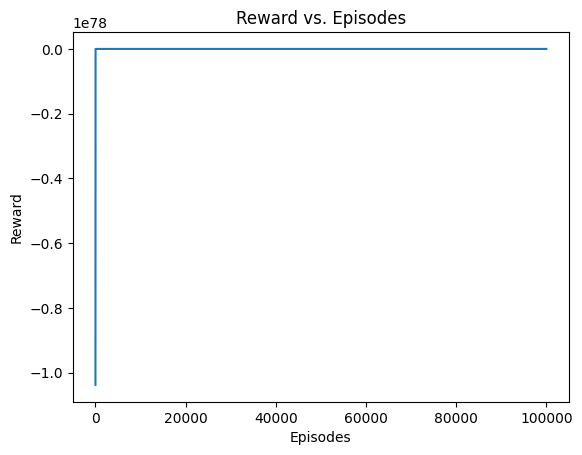

In [ ]:
#plt.plot(range(len(episode_rewards)), episode_rewards)
plt.plot(episode_rewards)
plt.xlabel('Episodes')
plt.ylabel('Reward')
#plt.ylim(0, 100)
plt.title('Reward vs. Episodes')
plt.show()

[nan, -184692.02397731334, -214572.5506627298, -195595.0820694386, -187871.3902185171, -176819.13993513584, -248564.2154217869, -234243.899317832, -188575.41793631538, -228724.38184401768, -193400.61749329706, -191600.78038673577, -225517.45180588128, -185730.17543286757, -242008.4724186188, -243322.0100551373, -226293.5023896279, -302088.5427795465, -232361.00942574203, -260029.04732265478, -337314.1079455879, -278073.24535303586, -225307.9058632319, -245738.36041740922, -219344.34856431017, -342227.20166304713, -313730.0719050149, -254232.93487765128, -319476.71389648784, -269462.8798589137, -225884.38138372285, -234085.52942550418, -414802.2971952856, -271080.3529418766, -249858.50429738272, -372398.67427648033, -315360.88831124216, -266594.0413298682, -279493.78657340194, -295234.8111753708, -356085.9136923686, -310262.7574499525, -267799.05466406373, -255508.43727538033, -307487.5089805778, -295197.6078356846, -312299.2589996474, -276923.2763009849, -292616.6224975716, -263107.548

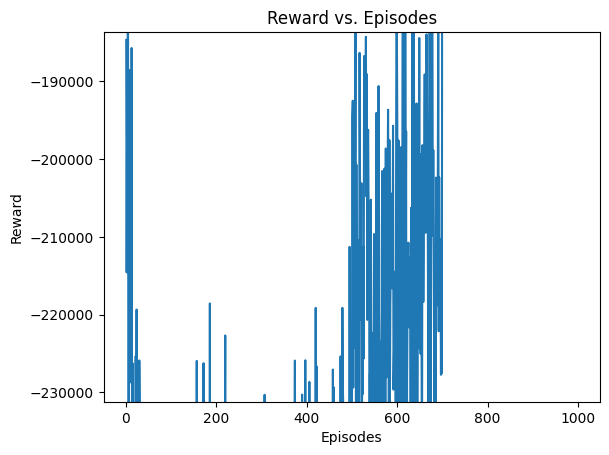

In [ ]:
Transp= np.transpose(Average_rewards)
minYlim = Average_rewards[1]
print(Average_rewards)
maxYlim = Average_rewards [1]
#plt.yscale('log')
plt.plot(range(len(Transp)),Transp)
for kkkk in range (len(Average_rewards)):
  if minYlim > Average_rewards[i]:
    minYlim =Average_rewards [i]
  if maxYlim < Average_rewards[i]:
    maxYlim =Average_rewards[i]

#plt.plot(np.transpose(Average_rewards),'ro')
plt.xlabel('Episodes')
plt.ylabel('Reward')
print (minYlim)
print (maxYlim)
plt.ylim(minYlim-2000,maxYlim+1000)
plt.title('Reward vs. Episodes')
plt.show()

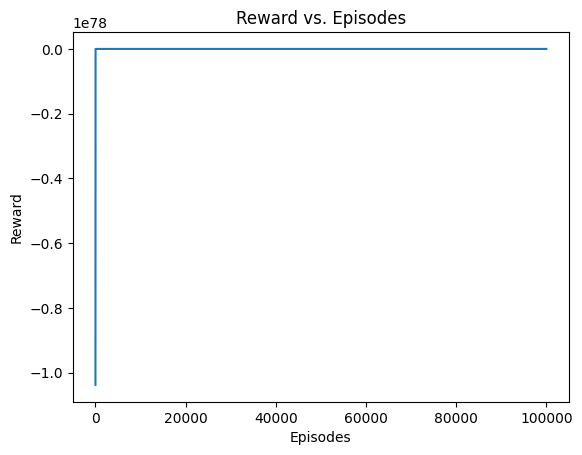

In [ ]:
#plt.plot(range(len(episode_rewards)), episode_rewards)
plt.plot(ac_reward)
plt.xlabel('Episodes')
plt.ylabel('Reward')
#plt.ylim(30, 50)
plt.title('Reward vs. Episodes')
plt.show()

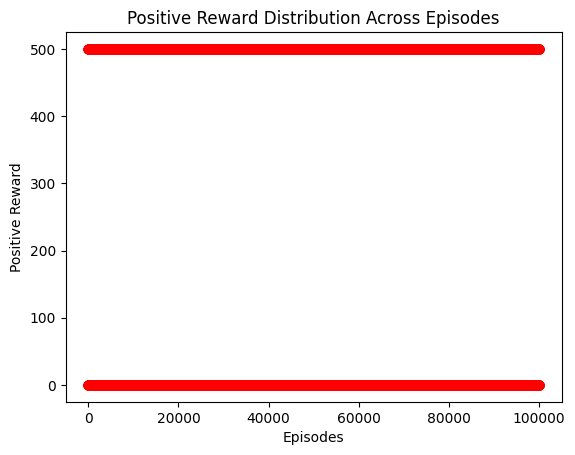

In [ ]:
#plt.plot(range(len(episode_positive_rewards_number)), episode_positive_rewards_number)
plt.plot(episode_positive_rewards_number,'ro')
plt.xlabel('Episodes')
plt.ylabel('Positive Reward')
plt.title('Positive Reward Distribution Across Episodes')
plt.show()

In [ ]:
agent.q_table

[[-1417.388499932613,
  -1379.823208626591,
  -1373.4226802515998,
  -1512.7286308652854,
  -1482.655015707639,
  -1422.5227548086775,
  -1456.9184633493498,
  -1443.3026779844138,
  -1445.1760428335924,
  -1379.6901721690433,
  -1432.889972489181,
  -1371.5147245577493,
  -1434.3773543652774,
  -1442.3680344349705,
  -1504.1368962709125,
  -1440.2561259899571,
  -1410.2074048605998,
  -1492.3105872356484,
  -1408.463900038589,
  -1433.7970394349006,
  -1408.3809904102236,
  -1479.1900607640478,
  -1442.688885213454,
  -1401.2432624752573,
  -1508.209285411292,
  -1462.6479729416549,
  -1371.6769753772442,
  -1399.5563202489384,
  -1363.96859978126,
  -1492.3747291281666,
  -1390.2784962974147,
  -1425.7639022358137,
  -1438.076369018838,
  -1400.990741261303,
  -1495.676930884263,
  -1345.3783207007664,
  -1482.7059297075186,
  -1430.2681768823945,
  -1448.9566202106682,
  -1426.9424752063533,
  -1424.7052161680422,
  -1307.6765963917758,
  -1520.7079211484538,
  -1458.7729888673678,


In [ ]:
Test__deadline_hit
print(np.average(Test__deadline_hit))

0.82598


In [ ]:
print(env.queue)


[[13, 20, 111, 272, 290, 315, 366, 374, 488], [73, 155, 194, 230, 370, 476], [35, 55, 119, 189, 237, 342, 429], [63, 98, 128, 209, 279, 378, 408, 437], [23, 85, 135, 220, 234, 361, 380], [76, 271, 363, 448, 477], [131, 140, 142, 150, 173, 203, 322], [1, 7, 68, 136, 149, 178, 499], [99, 105, 112, 144, 174, 273, 332, 396], [50, 118, 130, 233, 262, 319, 445, 464, 487], [32, 45, 54, 101, 214, 219, 416, 468, 483], [121, 133, 263, 268, 317, 497], [6, 77, 115, 127, 339, 389, 415], [28, 30, 40, 47], [12, 62, 107, 109, 407, 495], [27, 89, 147, 163, 243, 305, 309, 457], [22, 71, 84, 110, 338, 388, 474], [46, 132, 161, 185, 276, 277, 300], [33, 48, 67, 193, 229, 383, 398], [15, 100, 114, 200, 223, 286, 428], [42, 106, 113, 148, 269, 302, 334], [2, 11, 79, 158, 159, 172, 235, 412, 470], [18, 59, 92, 156, 184, 270, 453, 490], [152, 205, 289, 330, 471], [41, 58, 124, 201, 343, 347, 414], [51, 72, 108, 236, 251, 434], [9, 162, 190, 254, 261, 293, 391, 432], [82, 91, 96, 165, 314, 489], [10, 38, 66, 9

In [ ]:
Wait_queue


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.18541094e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.83194188e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.34117104e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.84794684e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.68559647e+00, 5.83304535e+00, 3.64566515e+00, 0.00000000e+00,
       1.05989960e+01, 0.00000000e+00, 0.00000000e+00, 2.89869090e+00,
       0.00000000e+00, 1.25935588e+00, 0.00000000e+00, 2.47589208e+01,
       2.68471524e+00, 1.29659335e+01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.16234142e+00, 2.77156575e+00,
      

In [ ]:
Makespan

array([1.44250256e+01, 4.18541094e+00, 3.83194188e+00, 2.98712722e+01,
       1.93858788e+01, 1.50934783e+01, 3.71207834e+00, 5.61361369e+00,
       3.52311059e+00, 4.60538789e+00, 3.64566515e+00, 6.41794316e+00,
       3.25691832e+00, 4.34117104e+00, 1.68559647e+00, 3.10659783e+00,
       3.57765896e+00, 3.91146622e+00, 5.06276647e+00, 1.83312419e+00,
       7.59538282e+00, 3.74424096e+01, 3.95754415e+00, 3.68598488e+00,
       3.25548996e+01, 4.56264525e+01, 2.89869090e+00, 2.89093978e+00,
       2.84794684e+00, 4.94479043e+00, 7.75104915e+00, 1.59797521e+00,
       1.25935588e+00, 2.68471524e+00, 5.03689720e+00, 2.77156575e+00,
       4.14744888e+00, 7.13288816e+00, 8.41889005e+00, 4.50210405e+01,
       1.41599248e+01, 1.91348458e+00, 4.16413370e+00, 5.91153242e+00,
       2.69593765e+00, 5.90298555e+00, 1.28342870e+00, 2.62715296e+01,
       4.51979927e+00, 1.57377859e+01, 1.91497068e+00, 4.36160341e+00,
       3.29124335e+00, 4.11638840e+00, 1.14007925e+01, 6.38652769e+00,
      

In [ ]:
RunTime

array([0.03502562, 0.04541094, 0.03594188, 0.04127215, 0.01587883,
       0.02347826, 0.04907834, 0.05820275, 0.07611059, 0.04738789,
       0.04666515, 0.06500127, 0.08591832, 0.04417104, 0.07259647,
       0.08559783, 0.08265896, 0.03246622, 0.11676647, 0.02912419,
       0.02521178, 0.01240961, 0.03654415, 0.05198488, 0.04489957,
       0.0364525 , 0.0356909 , 0.09793978, 0.04894684, 0.10979043,
       0.03410231, 0.04297521, 0.08535588, 0.02471524, 0.0388972 ,
       0.04856575, 0.07085241, 0.08284282, 0.0842249 , 0.0310405 ,
       0.04292879, 0.07048458, 0.0281337 , 0.04584152, 0.07793765,
       0.07362967, 0.0704287 , 0.06960883, 0.05308403, 0.07085241,
       0.06597068, 0.04460341, 0.07224335, 0.0603884 , 0.03845105,
       0.05396194, 0.05329949, 0.05978031, 0.07769323, 0.11011311,
       0.03015207, 0.03106419, 0.05958491, 0.04543488, 0.01420807,
       0.07422187, 0.08194855, 0.07156673, 0.03837544, 0.0298959 ,
       0.03872491, 0.04879594, 0.05554387, 0.06641509, 0.03440

In [ ]:
DTT

array([14.39 ,  4.14 ,  3.796, 29.83 , 19.37 , 15.07 ,  3.663,  1.37 ,
        3.447,  4.558,  3.599,  2.521,  3.171,  4.297,  1.613,  3.021,
        3.495,  3.879,  4.946,  1.804,  3.229, 37.43 ,  3.921,  3.634,
       32.51 , 45.59 ,  2.863,  2.793,  2.799,  4.835,  4.869,  1.555,
        1.174,  2.66 ,  4.998,  2.723,  2.391,  1.217,  4.689, 44.99 ,
        3.518,  1.843,  4.136,  2.967,  2.618,  4.57 ,  1.213,  1.443,
        1.782,  2.701,  1.849,  4.317,  3.219,  4.056,  4.2  ,  3.561,
        2.015,  2.103,  1.347,  4.215,  3.41 , 46.33 ,  2.178,  2.057,
       18.54 ,  3.885,  3.544,  1.589,  4.52 , 24.95 ,  3.834,  3.134,
        2.39 ,  2.23 ,  3.243, 39.1  ,  4.848,  2.966,  2.415,  4.312,
        4.712,  2.769,  3.645,  4.079,  1.969,  1.256,  2.668,  3.485,
        1.688,  2.123,  1.121,  1.81 ,  3.159,  3.598,  3.007,  3.575,
        3.357,  3.445,  3.86 ,  3.385,  2.231,  1.409,  2.298,  2.928,
        3.328,  1.641,  3.551,  3.203,  4.018,  3.608,  2.181,  4.43 ,
      

In [ ]:
Assigned_Resource

array([55.,  7., 21., 85., 81., 56., 12.,  7., 29., 26., 28., 21., 14.,
       32., 39., 19., 30., 31., 22., 34.,  0., 79., 16.,  4., 76., 46.,
       41., 15., 13., 36., 13., 43., 10., 18., 25.,  2., 76., 39., 28.,
       67., 13., 24., 20., 41., 40., 10., 17., 13., 18., 39.,  9., 58.,
       32., 42., 10.,  2., 38., 32., 24., 22., 37., 84., 14.,  3., 89.,
       42., 28., 18.,  7., 48., 43., 16., 25., 28., 36., 66.,  5., 12.,
       31., 21., 33., 37., 27., 40., 16.,  4., 42., 37., 34., 15., 33.,
       27., 80., 28., 40., 34., 27., 32.,  3.,  8., 19., 10., 31., 38.,
       42.,  8., 35., 14., 25., 14., 16.,  0.,  8., 20., 19., 12., 41.,
       39.,  9., 74., 34., 11., 38., 32., 24., 78., 32., 12.,  3., 30.,
        9.,  6., 17., 56., 30.,  4., 56., 38., 29., 88.,  6., 33.,  6.,
       71.,  8., 35., 64., 15., 20.,  7.,  6., 41., 23., 31., 35.,  1.,
       22., 30., 21., 21., 43., 17., 26., 15., 38., 27., 28., 86., 41.,
       58., 64., 85., 21.,  6.,  8., 59., 47., 87.,  7., 40., 54

In [ ]:
TaskData


array([1439., 4140., 3796., 2983., 1937., 1507., 3663., 1370., 3447.,
       4558., 3599., 2521., 3171., 4297., 1613., 3021., 3495., 3879.,
       4946., 1804., 3229., 3743., 3921., 3634., 3251., 4559., 2863.,
       2793., 2799., 4835., 4869., 1555., 1174., 2660., 4998., 2723.,
       2391., 1217., 4689., 4499., 3518., 1843., 4136., 2967., 2618.,
       4570., 1213., 1443., 1782., 2701., 1849., 4317., 3219., 4056.,
       4200., 3561., 2015., 2103., 1347., 4215., 3410., 4633., 2178.,
       2057., 1854., 3885., 3544., 1589., 4520., 2495., 3834., 3134.,
       2390., 2230., 3243., 3910., 4848., 2966., 2415., 4312., 4712.,
       2769., 3645., 4079., 1969., 1256., 2668., 3485., 1688., 2123.,
       1121., 1810., 3159., 3598., 3007., 3575., 3357., 3445., 3860.,
       3385., 2231., 1409., 2298., 2928., 3328., 1641., 3551., 3203.,
       4018., 3608., 2181., 4430., 4094., 3986., 3221., 2320., 1030.,
       3524., 4702., 2092., 1119., 3096., 2391., 4523., 3528., 3358.,
       1391., 4473.,

In [ ]:
TaskSize

array([ 376.,  142.,  141.,  340.,  130.,  216.,  213.,  182.,  245.,
        205.,  205.,  255.,  385.,  219.,  333.,  378.,  286.,  161.,
        351.,  140.,  125.,  139.,  173.,  165.,  342.,  358.,  109.,
        309.,  244.,  351.,  170.,  182.,  313.,  115.,  182.,  171.,
        325.,  380.,  370.,  338.,  214.,  352.,  101.,  140.,  260.,
        270.,  322.,  347.,  247.,  325.,  297.,  212.,  342.,  227.,
        141.,  190.,  210.,  283.,  388.,  331.,  115.,  256.,  267.,
        210.,  149.,  279.,  360.,  333.,  120.,  336.,  164.,  231.,
        264.,  264.,  110.,  371.,  323.,  391.,  145.,  385.,  219.,
        379.,  251.,  204.,  101.,  295.,  279.,  113.,  350.,  163.,
        341.,  236.,  341.,  241.,  121.,  356.,  262.,  383.,  222.,
        324.,  133.,  351.,  378.,  214.,  194.,  300.,  214.,  214.,
        393.,  396.,  109.,  203.,  145.,  296.,  247.,  316.,  198.,
        351.,  151.,  341.,  204.,  134.,  270.,  325.,  388.,  397.,
        374.,  351.,

In [ ]:
TaskDeadline

array([ 45.30022866,  13.43667174,  32.23766644,  34.65899178,
        27.83154961,  10.54980918,  20.93245467,  10.33087457,
        13.36012402,  24.58966395,  40.2988075 ,  42.00838619,
        46.4764907 ,  13.81496981,  34.36121266,  39.49581721,
        21.90854864,  34.33052614,  26.77699343,  34.54583597,
        21.97444406,  14.14094911,  29.08153725,  28.86266837,
        14.57480648,  33.02989161,  39.26644634,  15.57302944,
        11.61877502,  40.19397797,  43.04257738,  28.70743251,
        12.9498935 ,  10.37378289,  24.8280489 ,  27.09878069,
        19.31979789,  15.42794962,  31.34867199,  31.48676206,
        17.26061073,  14.50036832,  26.58196548,  28.71170828,
        15.58047053,  49.28536313,  17.51447003,  35.15807586,
        18.49148056,  31.96235747,  10.36679799,  48.00601248,
        42.63200968,  39.03994566,  43.88686158,  13.92274044,
        21.5712399 ,  19.26197595,  42.26156525,  49.35610434,
        14.94982212,  10.82797938,  19.61416117,  40.68

In [ ]:
MeetDealine

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
TaskData

array([1439., 4140., 3796., 2983., 1937., 1507., 3663., 1370., 3447.,
       4558., 3599., 2521., 3171., 4297., 1613., 3021., 3495., 3879.,
       4946., 1804., 3229., 3743., 3921., 3634., 3251., 4559., 2863.,
       2793., 2799., 4835., 4869., 1555., 1174., 2660., 4998., 2723.,
       2391., 1217., 4689., 4499., 3518., 1843., 4136., 2967., 2618.,
       4570., 1213., 1443., 1782., 2701., 1849., 4317., 3219., 4056.,
       4200., 3561., 2015., 2103., 1347., 4215., 3410., 4633., 2178.,
       2057., 1854., 3885., 3544., 1589., 4520., 2495., 3834., 3134.,
       2390., 2230., 3243., 3910., 4848., 2966., 2415., 4312., 4712.,
       2769., 3645., 4079., 1969., 1256., 2668., 3485., 1688., 2123.,
       1121., 1810., 3159., 3598., 3007., 3575., 3357., 3445., 3860.,
       3385., 2231., 1409., 2298., 2928., 3328., 1641., 3551., 3203.,
       4018., 3608., 2181., 4430., 4094., 3986., 3221., 2320., 1030.,
       3524., 4702., 2092., 1119., 3096., 2391., 4523., 3528., 3358.,
       1391., 4473.,

In [ ]:
ResourcePerformance

array([ 4958.,  3975.,  3521.,  4622.,  3174.,  3347.,  3471.,  3127.,
        3060.,  4502.,  3667.,  4639.,  4340.,  4985.,  4481.,  3155.,
        4734.,  4572.,  4653.,  4416.,  3590.,  3923.,  3006.,  3804.,
        4994.,  4753.,  4326.,  4417.,  4393.,  3219.,  3460.,  4959.,
        4734.,  4679.,  4807.,  4133.,  3197.,  3814.,  3940.,  4587.,
        3336.,  3054.,  3759.,  4235.,  3040., 11323.,  9821., 11565.,
       11134.,  8245.,  8649.,  7158., 11854., 10949., 10735.,  7431.,
        9200., 10747., 10725.,  9396.,  9262.,  7649.,  7554.,  9214.,
       10847., 10568.,  9218., 10889., 10075., 11655., 10180., 10798.,
        7226., 11269., 11127.,  8706.,  7617., 10983., 10999., 11201.,
       11239.,  8187., 11076.,  7344.,  8241.,  8336.,  8300.,  8238.,
       11970., 10487.])

In [ ]:
Makespan

array([1.44250256e+01, 4.18541094e+00, 3.83194188e+00, 2.98712722e+01,
       1.93858788e+01, 1.50934783e+01, 3.71207834e+00, 5.61361369e+00,
       3.52311059e+00, 4.60538789e+00, 3.64566515e+00, 6.41794316e+00,
       3.25691832e+00, 4.34117104e+00, 1.68559647e+00, 3.10659783e+00,
       3.57765896e+00, 3.91146622e+00, 5.06276647e+00, 1.83312419e+00,
       7.59538282e+00, 3.74424096e+01, 3.95754415e+00, 3.68598488e+00,
       3.25548996e+01, 4.56264525e+01, 2.89869090e+00, 2.89093978e+00,
       2.84794684e+00, 4.94479043e+00, 7.75104915e+00, 1.59797521e+00,
       1.25935588e+00, 2.68471524e+00, 5.03689720e+00, 2.77156575e+00,
       4.14744888e+00, 7.13288816e+00, 8.41889005e+00, 4.50210405e+01,
       1.41599248e+01, 1.91348458e+00, 4.16413370e+00, 5.91153242e+00,
       2.69593765e+00, 5.90298555e+00, 1.28342870e+00, 2.62715296e+01,
       4.51979927e+00, 1.57377859e+01, 1.91497068e+00, 4.36160341e+00,
       3.29124335e+00, 4.11638840e+00, 1.14007925e+01, 6.38652769e+00,
      

In [ ]:
TaskDeadline

array([ 45.30022866,  13.43667174,  32.23766644,  34.65899178,
        27.83154961,  10.54980918,  20.93245467,  10.33087457,
        13.36012402,  24.58966395,  40.2988075 ,  42.00838619,
        46.4764907 ,  13.81496981,  34.36121266,  39.49581721,
        21.90854864,  34.33052614,  26.77699343,  34.54583597,
        21.97444406,  14.14094911,  29.08153725,  28.86266837,
        14.57480648,  33.02989161,  39.26644634,  15.57302944,
        11.61877502,  40.19397797,  43.04257738,  28.70743251,
        12.9498935 ,  10.37378289,  24.8280489 ,  27.09878069,
        19.31979789,  15.42794962,  31.34867199,  31.48676206,
        17.26061073,  14.50036832,  26.58196548,  28.71170828,
        15.58047053,  49.28536313,  17.51447003,  35.15807586,
        18.49148056,  31.96235747,  10.36679799,  48.00601248,
        42.63200968,  39.03994566,  43.88686158,  13.92274044,
        21.5712399 ,  19.26197595,  42.26156525,  49.35610434,
        14.94982212,  10.82797938,  19.61416117,  40.68

In [ ]:
Generated_Tasks_size

array([[ 123.,  199.,  305., ..., 1021., 2998., 1763.],
       [ 293.,  296.,  199., ..., 1453., 2194., 2398.],
       [ 357.,  259.,  253., ..., 2584., 3540., 2842.],
       ...,
       [ 255.,  271.,  293., ..., 2896., 2783., 3041.],
       [ 351.,  147.,  130., ..., 3382., 1828., 3332.],
       [ 376.,  142.,  141., ..., 3344., 2827., 2637.]])

In [ ]:
Generated_Tasks_Data

array([[4136., 3537., 1560., ...,  379.,  343.,  471.],
       [4799., 1028., 1562., ...,  343.,  107.,  419.],
       [1354., 4534., 3113., ...,  176.,  314.,  206.],
       ...,
       [2333., 2779., 4439., ...,  323.,  436.,  155.],
       [1391., 4349., 2908., ...,  297.,  287.,  266.],
       [1439., 4140., 3796., ...,  335.,  125.,  291.]])

In [ ]:
Generated_Tasks_Deadline

array([[ 33.77597867,  26.73451046,  48.67802938, ..., 124.77466758,
        180.66504772,  53.8873735 ],
       [ 43.04669545,  49.98233698,  21.32560555, ..., 197.55091367,
         64.63809433,  65.56843786],
       [ 43.54034469,  26.95613058,  16.6182629 , ..., 218.18430036,
        224.88406487, 241.34283592],
       ...,
       [ 14.56948885,  17.66616902,  34.90095482, ..., 223.07174848,
        193.07890117, 163.88486018],
       [ 20.40493201,  30.42286907,  40.37526746, ...,  90.95876264,
        180.62742147, 248.01670866],
       [ 45.30022866,  13.43667174,  32.23766644, ...,  91.95014948,
        119.07355785,  51.44347645]])

In [ ]:
Generated_Tasks_prio

array([[3., 5., 5., ..., 1., 2., 1.],
       [5., 3., 4., ..., 2., 1., 2.],
       [4., 5., 4., ..., 2., 1., 2.],
       ...,
       [5., 4., 3., ..., 1., 2., 2.],
       [4., 5., 5., ..., 1., 2., 1.],
       [4., 3., 3., ..., 2., 1., 1.]])

In [ ]:
Generated_Tasks_prio_Normalized

array([[0.00134168, 0.00991374, 0.00991374, ..., 0.00018158, 0.00049358,
        0.00018158],
       [0.010688  , 0.00144646, 0.0039319 , ..., 0.00053212, 0.00019576,
        0.00053212],
       [0.00395081, 0.01073941, 0.00395081, ..., 0.00053468, 0.0001967 ,
        0.00053468],
       ...,
       [0.01090217, 0.00401068, 0.00147545, ..., 0.00019968, 0.00054279,
        0.00054279],
       [0.00399605, 0.01086239, 0.01086239, ..., 0.00019895, 0.00054081,
        0.00019895],
       [0.00396132, 0.00145729, 0.00145729, ..., 0.00053611, 0.00019722,
        0.00019722]])

In [ ]:
import csv

from google.colab import drive
drive.mount('/content/drive')


# Specify the file name
file_path = '/content/drive/My Drive/Colab Notebooks/hit_deadline.csv'
# Write the list to a CSV file
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(Test__deadline_hit)

print(f'The list has been written to {file_path}.')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The list has been written to /content/drive/My Drive/Colab Notebooks/hit_deadline.csv.


In [ ]:
import csv

from google.colab import drive
drive.mount('/content/drive')


# Specify the file name
file_path = '/content/drive/My Drive/Colab Notebooks/violation_time.csv'
# Write the list to a CSV file
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(Test__violation_time)

print(f'The list has been written to {file_path}.')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The list has been written to /content/drive/My Drive/Colab Notebooks/violation_time.csv.


In [ ]:
totalnodes=7

ResourcePerformance=np.zeros(totalnodes)
for i in range(totalnodes):
  if i<nfog:
     ResourcePerformance[i]=random.randint(a_size_fognode,b_size_fognode)
  else:
     ResourcePerformance[i]=random.randint(a_size_cloudnode,b_size_cloudnode)


ResourcePerformance

array([3658., 3769., 4013., 3963., 3660., 4235., 4144.])

In [ ]:
class Task:
    def __init__(self, id, processing_time, deadline):
        self.id = id
        self.processing_time = processing_time
        self.deadline = deadline

def edf(tasks, machines):
    tasks.sort(key=lambda x: x.deadline)  # Sort tasks based on deadlines
    schedule = [[] for _ in range(machines)]  # Initialize schedule for each machine

    for task in tasks:
        earliest_machine = min(range(machines), key=lambda m: sum([t.processing_time for t in schedule[m]]))
        schedule[earliest_machine].append(task)

    return schedule

# Example Usage:
if __name__ == "__main__":
    n = 5  # Number of tasks
    m = 3  # Number of machines

    # Example tasks (id, processing_time, deadline)
    tasks = [Task(1, 3, 5), Task(2, 2, 8), Task(3, 4, 10), Task(4, 1, 3), Task(5, 2, 6)]

    result_schedule = edf(tasks, m)

    # Print the schedule for each machine
    for i, machine_schedule in enumerate(result_schedule):
        print(f"Machine {i + 1} Schedule:")
        for task in machine_schedule:
            print(f"Task {task.id} (Processing Time: {task.processing_time}, Deadline: {task.deadline})")
        print()

Machine 1 Schedule:
Task 4 (Processing Time: 1, Deadline: 3)
Task 2 (Processing Time: 2, Deadline: 8)

Machine 2 Schedule:
Task 1 (Processing Time: 3, Deadline: 5)

Machine 3 Schedule:
Task 5 (Processing Time: 2, Deadline: 6)
Task 3 (Processing Time: 4, Deadline: 10)



In [ ]:
class Task:
    def __init__(self, id, processing_time, deadline):
        self.id = id
        self.processing_time = processing_time
        self.deadline = deadline

def edf(tasks, machines):
    tasks.sort(key=lambda x: x.deadline)  # Sort tasks based on deadlines
    schedule = [[] for _ in range(machines)]  # Initialize schedule for each machine

    for task in tasks:
        earliest_machine = find_earliest_machine(schedule)
        schedule[earliest_machine].append(task)

    return schedule

def find_earliest_machine(schedule):
    earliest_machine = 0
    earliest_time = sum(task.processing_time for task in schedule[earliest_machine])

    for i in range(1, len(schedule)):
        current_time = sum(task.processing_time for task in schedule[i])
        if current_time < earliest_time:
            earliest_machine = i
            earliest_time = current_time

    return earliest_machine

# Example Usage:
if __name__ == "__main__":
    n = 5  # Number of tasks
    m = 3  # Number of machines

    # Example tasks (id, processing_time, deadline)
    tasks = [Task(1, 3, 5), Task(2, 2, 8), Task(3, 4, 10), Task(4, 1, 3), Task(5, 2, 6)]

    result_schedule = edf(tasks, m)

    # Print the schedule for each machine
    for i, machine_schedule in enumerate(result_schedule):
        print(f"Machine {i + 1} Schedule:")
        for task in machine_schedule:
            print(f"Task {task.id} (Processing Time: {task.processing_time}, Deadline: {task.deadline})")
        print()

Machine 1 Schedule:
Task 4 (Processing Time: 1, Deadline: 3)
Task 2 (Processing Time: 2, Deadline: 8)

Machine 2 Schedule:
Task 1 (Processing Time: 3, Deadline: 5)

Machine 3 Schedule:
Task 5 (Processing Time: 2, Deadline: 6)
Task 3 (Processing Time: 4, Deadline: 10)



In [ ]:
import pandas as pd
df = pd.DataFrame (Average_rewards)


filepath = '/content/drive/My Drive/Colab Notebooks/reward.xlsx'

df.to_excel(filepath, index=False)


In [ ]:
print(N_high_priority_task)
print(N_low_priority_task)


[166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166.
 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166.
 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166.
 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166.
 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166.
 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166.
 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166.
 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166.
 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166.
 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166.
 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166.
 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166.
 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166.
 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166. 166.
 166. 

In [ ]:
print(high_priority_miss_deadline)
print(low_priority_miss_deadline)
np.mean(high_priority_miss_deadline+low_priority_miss_deadline)

[23. 24. 26. 23. 19. 25. 28. 25. 21. 22. 26. 16. 24. 22. 19. 24. 19. 19.
 30. 21. 20. 16. 25. 20. 25. 22. 24. 22. 20. 23. 30. 29. 22. 21. 24. 22.
 22. 20. 14. 21. 27. 24. 20. 22. 21. 21. 19. 18. 28. 25. 19. 20. 25. 20.
 20. 22. 24. 21. 23. 23. 24. 32. 22. 24. 27. 28. 33. 31. 21. 21. 21. 26.
 22. 27. 27. 28. 16. 17. 25. 25. 20. 23. 27. 28. 17. 20. 19. 16. 23. 27.
 26. 23. 24. 24. 23. 15. 21. 23. 19. 20. 17. 22. 24. 24. 21. 24. 24. 17.
 25. 23. 19. 18. 26. 24. 19. 28. 21. 25. 17. 21. 25. 27. 24. 29. 32. 23.
 19. 23. 22. 16. 16. 23. 19. 23. 25. 21. 19. 22. 22. 25. 20. 22. 28. 21.
 23. 27. 25. 28. 22. 20. 24. 20. 19. 19. 27. 26. 18. 15. 30. 23. 20. 24.
 20. 28. 22. 23. 26. 28. 24. 22. 22. 23. 30. 22. 24. 22. 21. 21. 17. 24.
 20. 24. 25. 26. 26. 13. 22. 20. 27. 29. 20. 12. 21. 16. 22. 26. 21. 25.
 19. 28. 25. 21. 20. 23. 24. 22. 26. 24. 21. 20. 22. 19. 22. 20. 27. 23.
 23. 20. 28. 25. 24. 18. 22. 19. 19. 20. 23. 26. 20. 23. 31. 21. 24. 24.
 21. 25. 22. 22. 23. 28. 23. 21. 25. 22. 25. 28. 21

88.51666666666667

In [ ]:
high_priority__violation_time
print(np.mean(high_priority__violation_time))
print(np.var(high_priority__violation_time))


272.8284380102918
3584.6337261689764


In [ ]:
low_priority__violation_time
print(np.mean(low_priority__violation_time))
print(np.var(low_priority__violation_time))



9699.989308545373
858335.3873654439


In [ ]:
print(np.mean(high_priority__violation_time+low_priority__violation_time))


9972.817746555666


In [ ]:

print(np.average(high_priority__violation_time))
print(np.var(high_priority__violation_time))
print(np.mean(high_priority__violation_time))

average_high_priority=high_priority__violation_time/N_high_priority_task




272.8284380102918
3584.6337261689764
272.8284380102918


In [ ]:
average_low_priority=low_priority__violation_time/N_low_priority_task
average_low_priority
print(np.average(average_low_priority))


29.041884157321473


In [ ]:
average_high_priority=high_priority__violation_time/N_high_priority_task
average_high_priority
print(np.average(average_high_priority))

1.6435448072909151


In [ ]:
np.average(average_high_priority)


1.6435448072909151

In [ ]:

def Random_action(state):
     return random.randint(0, totalnodes - 1)


for j in range(Testsize):
  Normalized_TaskPriority = softmax(TaskPriority)
  Generated_Tasks_size[j]=TaskSize
  Generated_Tasks_Data[j]=TaskData
  Generated_Tasks_Deadline[j]=TaskDeadline
  Generated_Tasks_prio[j]=TaskPriority

  Generated_Tasks_prio_Normalized[j]=Normalized_TaskPriority
  env.Reset_ResourceQueue()
  for task in range(n):
      state = task
      action = Random_action(state)
      node = action
      env.check_deadline(state,action,j)
      '''
      if node < nfog:
          print(f"Task {task+1} scheduled on Fog Node {node+1}")
      else:
          print(f"Task {task+1} scheduled on Cloud Node {node+1}")
     '''

In [ ]:
high_priority__violation_time

print('FCFS')

print(np.mean(high_priority__violation_time))


FCFS
272.8284380102918


In [ ]:
low_priority__violation_time
print('FCFS')
print(np.mean(low_priority__violation_time))
print(np.var(low_priority__violation_time))


FCFS
9699.989308545373
858335.3873654439
